# OCR 모델 비교하기   

- keras-ocr   
- tesseract   

In [7]:
import os
import matplotlib.pyplot as plt
import keras_ocr
import pytesseract
from PIL import Image
from pytesseract import Output
import cv2

### 검증용 데이터셋 준비

In [3]:
data_path = os.getenv('HOME')+ '/aiffel/ocr_python/image'
data_path

'/aiffel/aiffel/ocr_python/image'

In [6]:
# 입력 이미지 경로 
file_list = os.listdir(data_path)
file_path = [data_path+'/'+name for name in file_list]
file_path = sorted(file_path)
file_path

['/aiffel/aiffel/ocr_python/image/01.jpg',
 '/aiffel/aiffel/ocr_python/image/02.jpg',
 '/aiffel/aiffel/ocr_python/image/03.jpg',
 '/aiffel/aiffel/ocr_python/image/04.jpg',
 '/aiffel/aiffel/ocr_python/image/05.jpg',
 '/aiffel/aiffel/ocr_python/image/06.jpg',
 '/aiffel/aiffel/ocr_python/image/07.jpg',
 '/aiffel/aiffel/ocr_python/image/08.jpg']

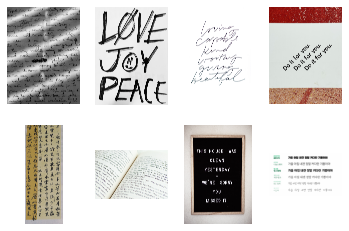

In [23]:
fig = plt.figure()
rows = 2
cols = 4
i = 1

for filename in file_path:
    img = cv2.imread(filename)
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.axis("off")
    i += 1

plt.show()

이미지는 8장을 준비했다.   
1번, 명암이 있는 필기체. 밝고 어두운 부분이 인식에 영향을 줄까 궁금해서 가져옴.      
2번, 캘리그라피.   
3번, 필기체.   
4번, 대각선으로 쓰인 글씨.   
5번, 한자. 인식이 될까 궁금해서 가져와봤다. 테서렉트에선 언어를 중국어로 하면 될까?  
6번, 책. 글자가 조금 흐릿하게 보임. 어떻게 인식될지 궁금해서 가져왔음.   
7번, 정상적인 글자. 인식이 제일 잘될것으로 예상.   
8번, 한글. 폰트도 여러 종류로 있음. keras-ocr에선 한글을 인식하지 못한다고 함.

## keras-ocr

In [24]:
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [25]:
images = [keras_ocr.tools.read(path) for path in file_path]
prediction_groups = [pipeline.recognize({path}) for path in file_path]

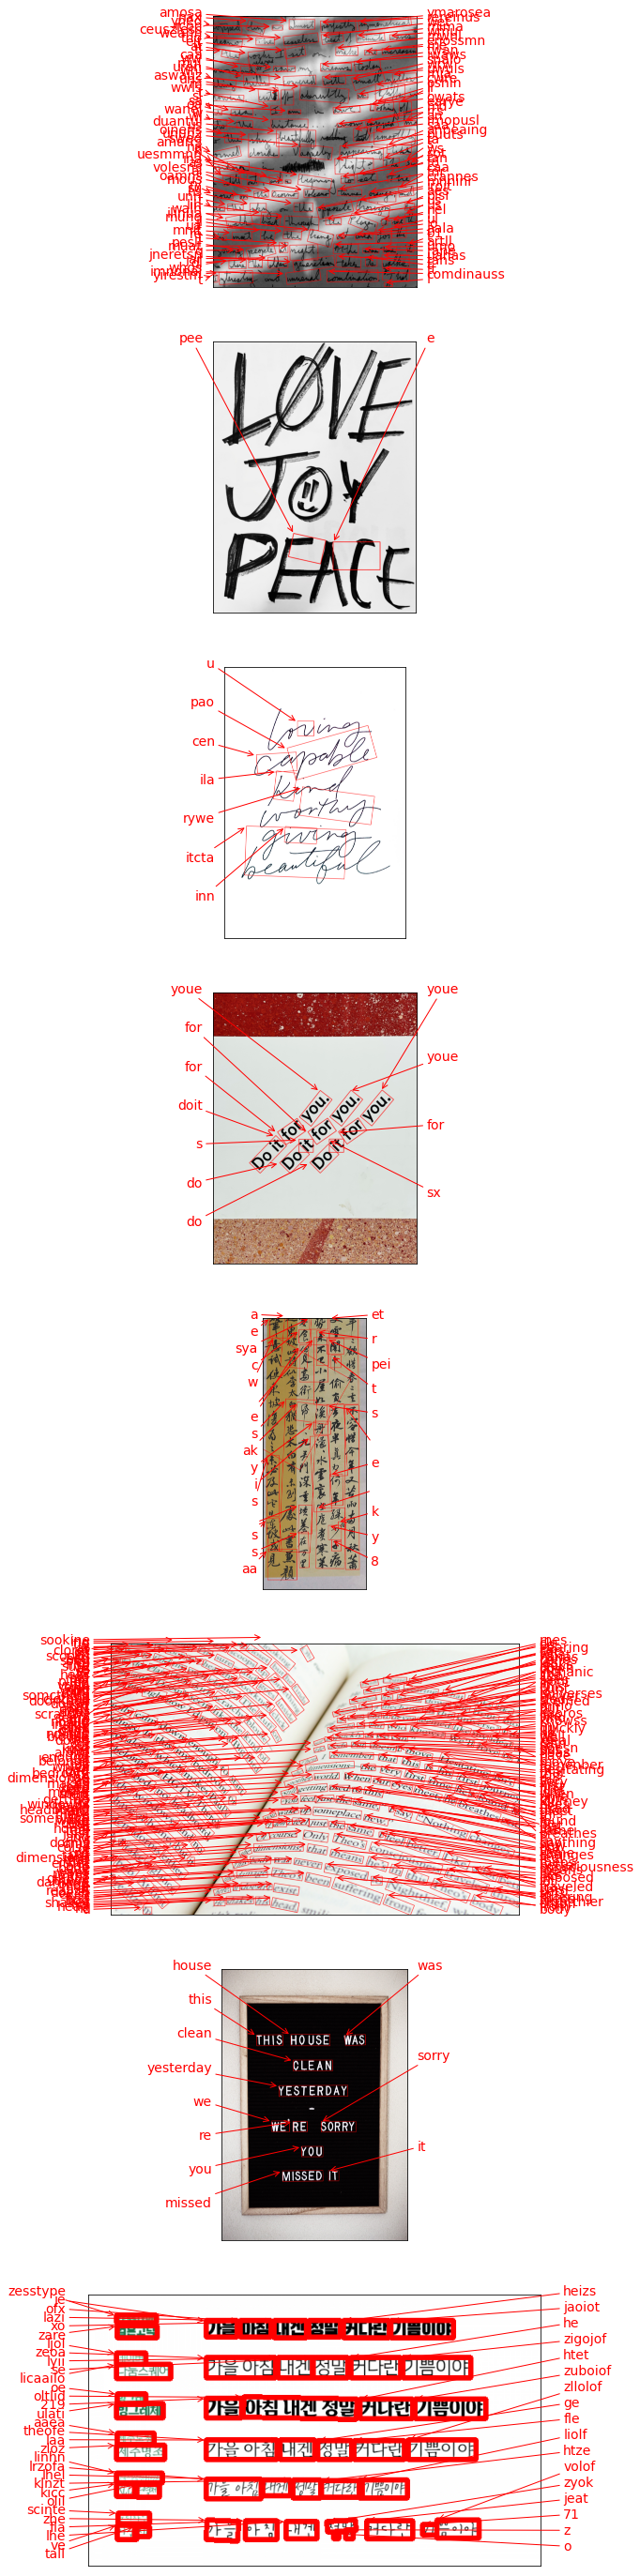

In [27]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(50, 50))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

- 1번, 3번 이미지.   
  필기체는 인식이 전혀 안된다!   
- 2번 이미지.   
  그리고 예상했던 것과 다르게 필라그래피도 인식이 안된 것을 확인할 수 있었다.   
  필라그래피는 그래도 알파벳 모양이 잘 보여서 인식이 잘 될줄 알았는데.   
- 5번, 8번 이미지.   
  한글과 한자는 예상했던것처럼 인식하지 못했다.   
- 4번, 7번 이미지.   
  4번은 대각선이라 그런지 살짝 이상하게 인식된 부분이 있었다.   
  "you." 에서 "."을 "e"로 인식하거나, "it"를 "s", "sx"로 인식한 부분.   
  7번은 이미지 자체가 깔끔한 알파벳이라 인식이 매우 잘 됐다.   

## Tesseract

In [28]:
# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 영어라면 lang='eng', 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

#### 1번 이미지

In [29]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/image'
img_file_path = work_dir + '/01.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

In [30]:
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/image/0000.png


In [31]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [32]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


Done


1번 이미지는 인식이 안됐다.

#### 2번 이미지

In [33]:
img_file_path = work_dir + '/02.jpg'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/image/0000.png


In [34]:
recognize_images(cropped_image_path_list)

|

Done


필라그래피도 인식이 안된다.

#### 3번 이미지

In [35]:
img_file_path = work_dir + '/03.jpg'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/image/0000.png


In [36]:
recognize_images(cropped_image_path_list)

a

Done


필기체도 인식이 안된다.

#### 4번 이미지

In [39]:
img_file_path = work_dir + '/04.jpg'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/image/0000.png
/aiffel/aiffel/ocr_python/image/0001.png


In [40]:
recognize_images(cropped_image_path_list)



Done


4번도 안됐다.   

이미지가 어떻게 나온건지 확인해봤는데   
해당 이미지에서 위쪽과 아래쪽만 분리하고 중간의 글자가 있는 부분이 없다.   
왜 이런지는 모르겠다.   

#### 5번 이미지

중국어 간체의 경우 tesseract-ocr-chi-sim   
간체 세로쓰기는 tesseract-ocr-chi-sim-vert   
해당 이미지는 간체 세로쓰기인거 같으니 아래껄로 설치해주었다.

In [44]:
def crop_word_regions_ch(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='chi_sim_vert',    # 영어라면 lang='eng', 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [45]:
img_file_path = work_dir + '/05.jpg'

cropped_image_path_list = crop_word_regions_ch(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/image/0000.png
/aiffel/aiffel/ocr_python/image/0001.png
/aiffel/aiffel/ocr_python/image/0002.png
/aiffel/aiffel/ocr_python/image/0003.png
/aiffel/aiffel/ocr_python/image/0004.png
/aiffel/aiffel/ocr_python/image/0005.png
/aiffel/aiffel/ocr_python/image/0006.png
/aiffel/aiffel/ocr_python/image/0007.png
/aiffel/aiffel/ocr_python/image/0008.png
/aiffel/aiffel/ocr_python/image/0009.png
/aiffel/aiffel/ocr_python/image/0010.png
/aiffel/aiffel/ocr_python/image/0011.png
/aiffel/aiffel/ocr_python/image/0012.png
/aiffel/aiffel/ocr_python/image/0013.png
/aiffel/aiffel/ocr_python/image/0014.png
/aiffel/aiffel/ocr_python/image/0015.png
/aiffel/aiffel/ocr_python/image/0016.png
/aiffel/aiffel/ocr_python/image/0017.png
/aiffel/aiffel/ocr_python/image/0018.png
/aiffel/aiffel/ocr_python/image/0019.png
/aiffel/aiffel/ocr_python/image/0020.png
/aiffel/aiffel/ocr_python/image/0021.png
/aiffel/aiffel/ocr_python/image/0022.png
/aiffel/aiffel/ocr_python/image/0023.png
/aiffel/aiffel/o

In [46]:
def recognize_images_ch(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='chi_sim_vert',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [47]:
recognize_images_ch(cropped_image_path_list)



) 丰

W

全

>M



三

Yi


SN

恬 和

大

二


忆

-

堆


验

丽

呈

以

全

N

>

所

人

] ) - 一

(中


和



必

大

衬


和


和


一



于








局

\ 人 《人

了 中

?了



半 ,


沁

Done


인식이 되는것 같긴 한데 애매하다..   

#### 6번 이미지

In [48]:
img_file_path = work_dir + '/06.jpg'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/image/0000.png
/aiffel/aiffel/ocr_python/image/0001.png
/aiffel/aiffel/ocr_python/image/0002.png
/aiffel/aiffel/ocr_python/image/0003.png
/aiffel/aiffel/ocr_python/image/0004.png
/aiffel/aiffel/ocr_python/image/0005.png
/aiffel/aiffel/ocr_python/image/0006.png
/aiffel/aiffel/ocr_python/image/0007.png
/aiffel/aiffel/ocr_python/image/0008.png
/aiffel/aiffel/ocr_python/image/0009.png
/aiffel/aiffel/ocr_python/image/0010.png
/aiffel/aiffel/ocr_python/image/0011.png
/aiffel/aiffel/ocr_python/image/0012.png
/aiffel/aiffel/ocr_python/image/0013.png
/aiffel/aiffel/ocr_python/image/0014.png
/aiffel/aiffel/ocr_python/image/0015.png
/aiffel/aiffel/ocr_python/image/0016.png
/aiffel/aiffel/ocr_python/image/0017.png
/aiffel/aiffel/ocr_python/image/0018.png
/aiffel/aiffel/ocr_python/image/0019.png
/aiffel/aiffel/ocr_python/image/0020.png
/aiffel/aiffel/ocr_python/image/0021.png
/aiffel/aiffel/ocr_python/image/0022.png
/aiffel/aiffel/ocr_python/image/0023.png
/aiffel/aiffel/o

In [49]:
recognize_images(cropped_image_path_list)

‘

,

*

,


*

/

#

‘

#*

Z


i

&

_

>

j

I

f

¢

a»

fe efi


(NCC Nar,



a

J.



= ™

is

 fraere

if

taf

“or

IC*

7


fv)

*

wshl

if,

fue

it-/

C“¢

‘

sé

Ar,


\ 1 <

i

picklyv

<t.>

14/7

Sr

i)

7

i)

Zs.

oe

&

Caz). ’

>

Ye

}


Sie

( ys

Dirt

Wesy,

Zz

E

x

remember

CDar

7

=

Ve

fy


lc)

j

Ris

“SIta ly

fe

yy

Bs

LS

*-


st

Ler

OlTr

Lirs,

cy

Ly


{Sn

t

F

i!

peers

LIsec”d

LO

thy

Ves

422¢

{Ne

Pics

Ow,

-— *

=

¥

i you

feel

plise

Che


::

.

J]

wake e

ip

SOT77


yO#

L2e

I


te¢

o

wi

Go!

4 Feel

Jlist

fe

- lv

Ne

Ch y

Uz

SQ i? ? co

LI

COUTSE.

C)77/

5

Z

C

4

yc

Lunenslons,

ff).

é


Fi

DOD V

4S

4s

‘or

»

Jes ‘

ett

a

>» 7e11SIONS—§t-fy ws

-£f2

- ting

e

er

Le 2

y

Fe

Dad Aage

200

,

De


Ty

“¢

Ate

oe

os



위쪽은 이미지가 흐릿해서 잘 인식이 되지 않는다.   
아래로 갈수록 단어가 몇몇개 보이는것같지만 이 역시도 단어 크기가 작아서 그런지 잘 안되는것 같다.   

#### 7번 이미지

In [50]:
img_file_path = work_dir + '/07.jpg'

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/image/0000.png
/aiffel/aiffel/ocr_python/image/0001.png
/aiffel/aiffel/ocr_python/image/0002.png
/aiffel/aiffel/ocr_python/image/0003.png
/aiffel/aiffel/ocr_python/image/0004.png


In [51]:
recognize_images(cropped_image_path_list)

Ina

HOUSE

oe

YESTERDAY

4

Done


7번 이미지는 인식이 잘 될거라고 예상했는데 틀렸다.

#### 8번 이미지

In [52]:
def crop_word_regions_kr(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 영어라면 lang='eng', 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [53]:
img_file_path = work_dir + '/08.jpg'

cropped_image_path_list = crop_word_regions_kr(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/image/0000.png
/aiffel/aiffel/ocr_python/image/0001.png
/aiffel/aiffel/ocr_python/image/0002.png
/aiffel/aiffel/ocr_python/image/0003.png
/aiffel/aiffel/ocr_python/image/0004.png
/aiffel/aiffel/ocr_python/image/0005.png
/aiffel/aiffel/ocr_python/image/0006.png
/aiffel/aiffel/ocr_python/image/0007.png
/aiffel/aiffel/ocr_python/image/0008.png
/aiffel/aiffel/ocr_python/image/0009.png
/aiffel/aiffel/ocr_python/image/0010.png
/aiffel/aiffel/ocr_python/image/0011.png
/aiffel/aiffel/ocr_python/image/0012.png
/aiffel/aiffel/ocr_python/image/0013.png
/aiffel/aiffel/ocr_python/image/0014.png
/aiffel/aiffel/ocr_python/image/0015.png
/aiffel/aiffel/ocr_python/image/0016.png
/aiffel/aiffel/ocr_python/image/0017.png
/aiffel/aiffel/ocr_python/image/0018.png
/aiffel/aiffel/ocr_python/image/0019.png
/aiffel/aiffel/ocr_python/image/0020.png
/aiffel/aiffel/ocr_python/image/0021.png
/aiffel/aiffel/ocr_python/image/0022.png
/aiffel/aiffel/ocr_python/image/0023.png
/aiffel/aiffel/o

In [54]:
def recognize_images_kr(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

In [55]:
recognize_images_kr(cropped_image_path_list)

렴

교

[니크

가을

바침

14

지디

31 [르

/)|분

[]

1(}

[

가을

가짐

내겐

성말

커다란

기픈

[)

야

나눔스퀘어


그레체

가을

아짐

내겐

성말

커다란

기브

(]

|아

제주명조

가을

아짐

내게

성말

커다란

기브

010

「

가

아칭

나게

정갈

717

12

+

7|


야

은제

0) 글

날 .

7

가극

아실

_

나 그

저망

ㅋㄷ

+

-

7]

(”

10

…

Done


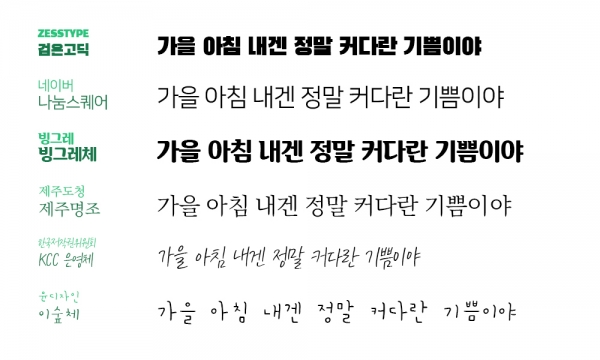   
한글 인식.   
인식이 제대로 안되는 폰트도 있다.   
그래도 꽤 잘 인식되는 폰트, 나눔스퀘어, 빙그레, 제주명조.   
검은 고딕은 폰트가 너무 굵어서, 그리고 나머지 둘은 폰트가 너무 얇아서 인식이 제대로 안된게 아닐까 생각이 든다.

## 테스트 결과 정리

- keras-ocr의 경우 영어만 인식이 가능했다.   
  필기체의 경우는 인식이 안됐고, 글자가 작거나 흐릿한 부분도 인식하지 못했다.   
  7번 이미지 같이 깔끔한 알파벳의 경우 매우 잘 인식되었다.   
  그리고 이미지로 인식된 부분을 바운딩 박스를 통해 표시해줘서, 어떻게 인식이 진행됐는지 한눈에 볼 수 있는 점이 좋았다.   
- tesseract는 추가적인 설치를 통해 한글이나 한자, 그리고 다른 언어들도 인식하게 할 수 있었다.   
  영어의 경우 필기체는 keras와 마찬가지로 전혀 인식이 안됐고,   
  멀쩡했던 4번이나 7번 이미지의 경우도 이상하게 일부분만 인식하긴했다.   

### 결과 분석과 결론 제시

- 서비스   
  문자 인식을 통한 텍스트 번역   
- 평가 기준   
  + 번역을 위해 다양한 언어에 대한 기능이 있어야함.   
  + 문자를 확실히 인식해야함.   
- 다양한 언어에 대한 기능은 tesseract에 있음. 하지만 문자 인식 성능은 좋지 못했다.  
  keras-ocr은 필기체, 캘리그래피 같은 변형된 문자를 인식하는데 어려움이 있음.   
  